# open bayesian regression
The below notebook will attempt to regress individual 2018 Reebok CrossFit Games Open workout scores using other Open workouts *and* benchmark metrics from athlete profiles. Here, the regression is the score the athlete attained on the workout and *not* their placement relative to other individuals. For example, if an athlete got 10 reps on a 1 minute AMRAP workout, then their score would be 10.

## imports

In [1]:
#pandas (dataframes)
import pandas as pd
#pymysql (mysql connector)
import pymysql as pms
#numpy (reshaping data)
import numpy as np
#scikit-learn
#regression
from sklearn.linear_model import LinearRegression
#train/test split
from sklearn.model_selection import train_test_split
#error calculation
from sklearn.metrics import mean_squared_error
#feature scaling
from sklearn.preprocessing import MinMaxScaler
#plotting
import matplotlib.pyplot as plt
import seaborn as sb
%matplotlib inline

# use for implementing custom modules
import sys
sys.path.insert(0, "../custom_modules/")

#custom modules
#grabbing data
from dataframer import grab_data
#seaborn styling
import seaborn_styler as sbs
#outlier/normal data separator
from outlier_filter import separate_outliers

### stylize seaborn
This only needs to be done once, and can be done anywhere prior to using Seaborn to achieve the intended styling.

In [2]:
sbs.stylize()

## getting database credentials
The database credentials can be read in from file. Note that this file is ignored in the public repo, so you'll need to make a version which corresponds to your database.

In [3]:
#this list object is passed around to functions requiring database access
#...the functions will open/close the connection themselves during calls
creds = []
#database credentials are stored in this file
with open("../database_credentials2.txt") as f:
    db_user = f.readline().strip()
    db_pass = f.readline().strip()
    db_name = f.readline().strip()
    db_host = f.readline().strip()
    creds = [db_host, db_user, db_pass,db_name]

## grabbing the data
At the time of writing this notebook, division 18 (Men's 35-39) has the most complete open entries. Therefore, we'll use this division for regression. Later, all division data can be scraped, and we can one hot encode the division_id labels.

For predictors, we'll use the Open workouts. There are 6 of them, 5 of which are metcons and 1 of which is a test of olympic weightlifting under fatigue. The independent variables we'll use here will be athlete profile benchmark statistics. These are a mix of strength and endurance tests.

### open workouts
Because of the way the data was filtered during scraping, any athletes who scaled/DNF(did not finish) were not written to the database. Because of this, no `WHERE` criteria is necessary.

In [4]:
#read into dataframe
open_keys = list(map(lambda x: "leaderboard_18_" + x, [
    "1_reps",
    "2_time_secs",
    "2a_weight_lbs",
    "3_time_secs",
    "4_time_secs",
    "5_reps"
]))
working_division = 18

open_data = grab_data(
    """
    SELECT id, {}
    FROM athlete
    WHERE division_id={}
    """.format(
        ", ".join(open_keys), working_division
    ),
    creds
)

open_data.head(3)

,id,leaderboard_18_1_reps,leaderboard_18_2_time_secs,leaderboard_18_2a_weight_lbs,leaderboard_18_3_time_secs,leaderboard_18_4_time_secs,leaderboard_18_5_reps
0,86,328,651,207,1373,637,77
1,93,309,480,235,1548,642,94
2,1636,402,316,260,1148,577,123


In [5]:
open_data.drop(["id"], axis=1).describe()

,leaderboard_18_1_reps,leaderboard_18_2_time_secs,leaderboard_18_2a_weight_lbs,leaderboard_18_3_time_secs,leaderboard_18_4_time_secs,leaderboard_18_5_reps
count,24544.000000,24544.000000,24544.000000,24544.000000,24544.000000,24544.000000
mean,281.465328,510.212842,211.107847,1375.548607,579.615751,78.611392
std,58.750398,112.649086,57.220177,366.248177,176.915058,33.489441
min,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
25%,255.000000,442.000000,188.000000,1312.000000,604.000000,70.000000
50%,284.000000,511.000000,217.000000,1539.000000,623.000000,84.000000
75%,319.000000,585.000000,245.000000,1548.000000,647.000000,99.000000
max,470.000000,829.000000,379.000000,1767.000000,704.000000,191.000000


### benchmark workouts
Although the Open workouts are complete for each entry in the database, the athlete profiles will not be. In fact, *most* athletes do not publish their benchmark stats in a complete manner. To see this, let's try and get the athletes which we have complete benchmark data for.


#### note on fight gone bad
Fight gone bad is a staple workout in CrossFit. Because of a oversight during scraping implementation, all of the first 130,743 athletes have invalid fight gone bad scores marked as -2 (when an entry was given). Because of this, fight gone bad is ignored during this analysis.

In [6]:
benchmark_keys = [
    "back_squat_lbs",
    "clean_and_jerk_lbs",
    "snatch_lbs",
    "deadlift_lbs",
    #"fight_gone_bad_reps",
    "max_pull_ups",
    "fran_time_secs",
    "grace_time_secs",
    "helen_time_secs",
    "filthy_50_time_secs",
    "sprint_400_m_time_secs",
    "run_5_km_time_secs"
]

benchmark_data = grab_data(
    """
    SELECT id, {}
    FROM athlete
    WHERE {}
        AND division_id = {}
        AND max_pull_ups !=- 2
    """.format(
        #key_a, key_b, ...
        ", ".join(benchmark_keys),
        #key_a != -1, key_b != -1, ...
        " AND ".join(list(map(lambda x: x + " != -1", benchmark_keys))),
        working_division
    ),
    creds
)

benchmark_data.head(3)

,id,back_squat_lbs,clean_and_jerk_lbs,snatch_lbs,deadlift_lbs,max_pull_ups,fran_time_secs,grace_time_secs,helen_time_secs,filthy_50_time_secs,sprint_400_m_time_secs,run_5_km_time_secs
0,86,335,265,210,415,32,226,174,496,1287,64,1325
1,93,305,235,185,355,45,220,154,493,1500,62,1239
2,1636,400,285,215,485,67,138,108,429,1056,58,1219


The below version of `benchmark_data` without the ID column is used throughout the notebook for iteration.

In [7]:
noid_benchmark_df = benchmark_data.drop(["id"], axis=1)
noid_benchmark_df.describe()

,back_squat_lbs,clean_and_jerk_lbs,snatch_lbs,deadlift_lbs,max_pull_ups,fran_time_secs,grace_time_secs,helen_time_secs,filthy_50_time_secs,sprint_400_m_time_secs,run_5_km_time_secs
count,556.000000,556.000000,556.000000,556.000000,556.000000,556.000000,556.000000,556.000000,556.000000,556.000000,556.000000
mean,358.257194,254.546763,202.480216,435.949640,39.976619,268.931655,262.055755,572.672662,1463.692446,122.631295,1351.856115
std,72.477648,47.007720,120.673133,79.178264,15.591907,409.283323,1325.064417,381.082542,516.225184,435.423897,424.966077
min,2.000000,10.000000,10.000000,10.000000,1.000000,119.000000,30.000000,60.000000,50.000000,2.000000,153.000000
25%,315.000000,225.000000,175.000000,396.000000,30.000000,165.000000,120.000000,477.000000,1167.500000,60.000000,1200.000000
50%,355.000000,255.000000,198.000000,440.000000,40.000000,209.000000,150.000000,523.500000,1375.000000,65.000000,1286.000000
75%,400.000000,285.000000,225.000000,485.000000,50.000000,276.250000,204.000000,587.000000,1620.000000,74.000000,1404.250000
max,715.000000,444.000000,2875.000000,726.000000,112.000000,5955.000000,30002.000000,5955.000000,5955.000000,5940.000000,6039.000000


## filtering the open data
Although this filtered dataset is quite small (athletes with complete open profiles), it can still be useful for dimensionality reduction and model evaluation. For exmpaple, specific Open workouts may not exhibit a relationship/dependency on metrics like `deadlift_lbs`. In these cases, athletes who have not filled out the deadlift field on their athlete profile can be included in such a workout analysis.

Below we'll filter the Open data to only those athletes contained in the benchmark dataframe.

In [8]:
filtered_open_df = open_data[open_data["id"].isin(benchmark_data["id"])]

#example data
filtered_open_df.head(3)

,id,leaderboard_18_1_reps,leaderboard_18_2_time_secs,leaderboard_18_2a_weight_lbs,leaderboard_18_3_time_secs,leaderboard_18_4_time_secs,leaderboard_18_5_reps
0,86,328,651,207,1373,637,77
1,93,309,480,235,1548,642,94
2,1636,402,316,260,1148,577,123


## outlier detection
Although there is a great amount of filtering that happens during data scraping, some outlier-like data is bound to slip in. To see this, look at the max row in the `benchmark_stats` describe call a 3 cells above. In order to filter outliers, we'll first plot 1-dimensional scatterplots for each of the benchmark stats. Notice how we're only talking about the benchmark stats. We're relying on CrossFit HQ's score validation to ensure integrity of Open scores (athletes submit scores to CrossFit and they have the ability to review/reject/adjust scores accordingly).

In [9]:
benchmark_colors = ["#0099ff", "#ff0059", "#66ff33"]

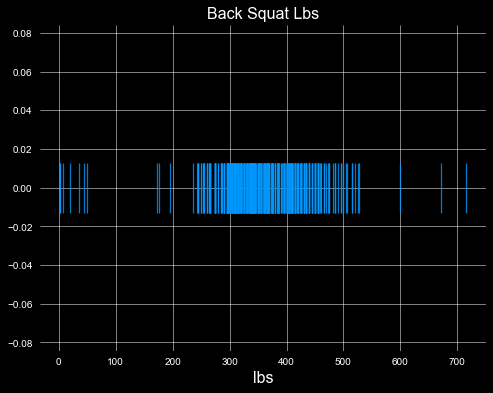

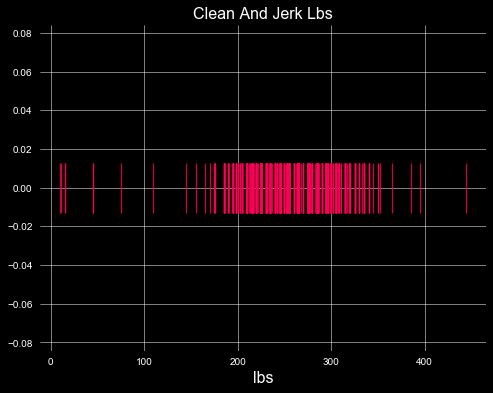

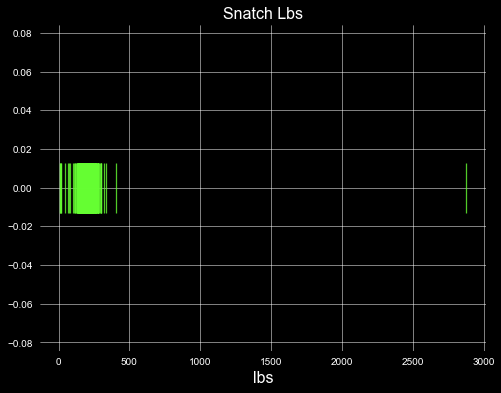

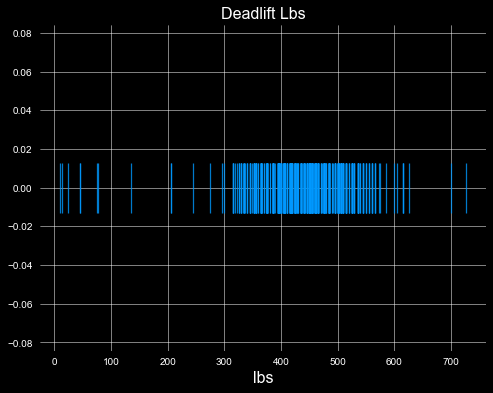

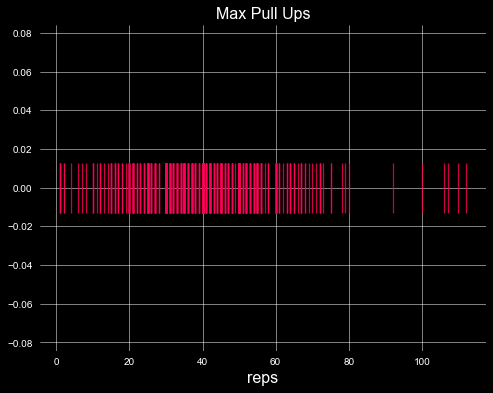

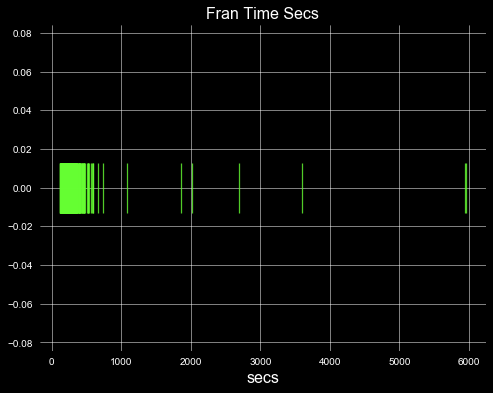

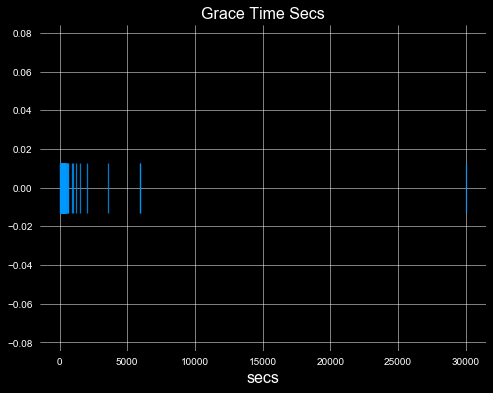

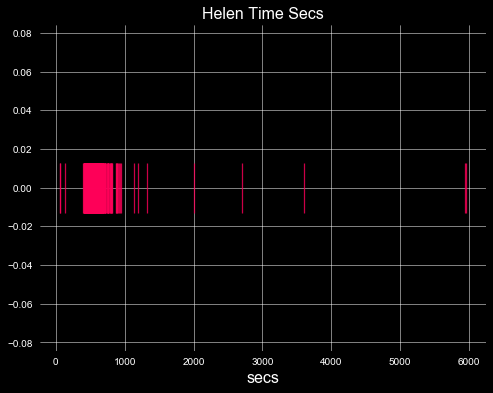

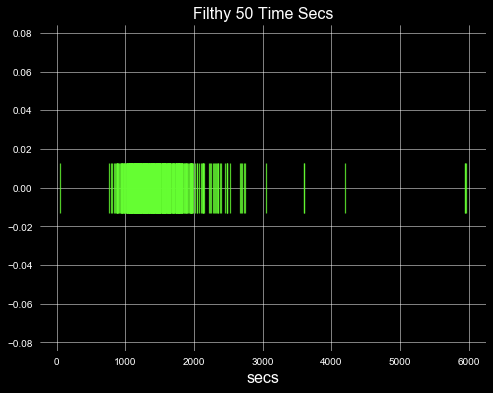

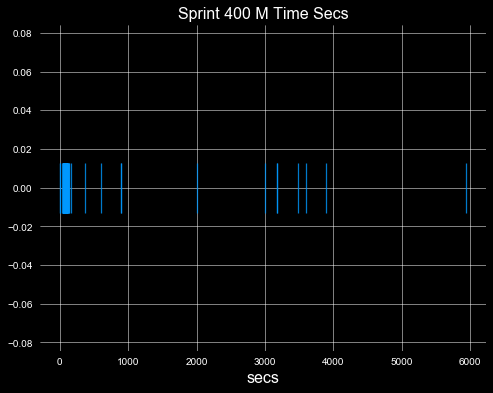

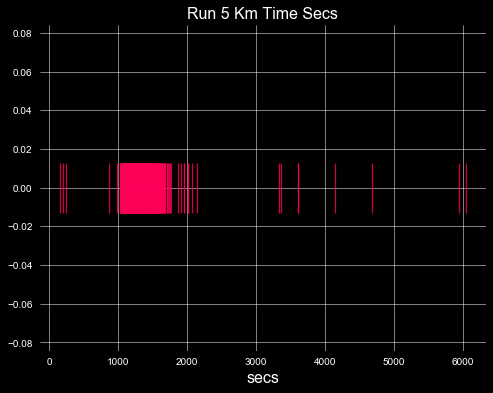

In [10]:
for i in range(len(noid_benchmark_df.columns)):
    #get column reference
    c = noid_benchmark_df.columns[i]
    sb.regplot(
        #x values
        noid_benchmark_df[c],
        #shift each 1d scatterplot up by 1 in the y axis
        np.zeros_like(noid_benchmark_df[c]),
        color=benchmark_colors[i % len(benchmark_colors)],
        fit_reg=False,
        marker="|",
        scatter_kws={"s": 2500}
    )
    #show individual plot
    c_words = c.split("_")
    plt.xlabel(c_words[-1] if c_words[-1] != "ups" else "reps")
    plt.title(c.replace("_", " ").title())
    plt.show()
        

### analyzing the graphs
Below we'll breakdown the workout behind each graph and what kind of entry we'll consider an outlier for each:
* back squat
    * Reasonable [back squat](https://www.youtube.com/watch?v=nOAqpYcyMGs) numbers are anything less than 1000 lbs. However, if an athlete has a backsquat exceeding 3x bodyweight, this is considered advanced strength and should be examined more carefully. To observe this, we'll need to grab the body weight for each of these athletes. Furthermore, we'll do this for clean and jerk, snatch, and deadlift as well.
* clean and jerk
    * From the graph distribution, most of these [clean and jerk](https://www.youtube.com/watch?v=58he7Xcwfws) entries seem reasonable (with the exception of the values < 100 lbs). Still, we'll replot these versus athlete bodyweight for confirmation.
* snatch
    * There's no way somebody is [snatching](https://www.youtube.com/watch?v=FBV-Xw640vQ) 600+ lbs in CrossFit in 2018, so the guy with an entry of 2800+lbs will be removed before replotting vs. bodyweight. Additionally, there are some suspiciously high entries (seeming 300-400 lbs range), so we'll look at these too.
* deadlift
    * Most of these [deadlift](https://www.youtube.com/watch?v=QY9F5-qB5QE) entries seem reasonable. Even the 700 lbs entries are possible, but we'll hold >= 700 and <= 200 as suspicious for the time being.
* max pull ups
    * [Butterfly/kipping](https://www.youtube.com/watch?v=Jp7-5gbtfOY) and [strict](https://www.youtube.com/watch?v=FC74Pa9WTVw) pullups are very difficult to achieve high repitions on (50+ for butterfly/kipping, 30+ for strict). Most if not all of the entries on the athlete profile should correspond to a butterfly/kipping variant. Although many athletes have 50-80 pull ups, we'll plot these scores vs. bodyweight, and pay special attention to athletes claiming 90+ reps.
* fran
    * [Fran](https://www.youtube.com/watch?v=Rlc1O5_43YQ) is meant to be a very fast workout (well under 10 minutes if it's done/scaled properly). Athletes exceeding 600 seconds in their entries most likely haven't updated their profile, are unfit, or, in extremely high-time circumstances, are trolling.
* grace
    * [Grace](https://www.youtube.com/watch?v=_g__U-nkQts), similar to Fran, should be done very quickly (even faster than Fran). High time athletes will be scrutinized after replotting vs. clean and jerk weight.
* helen
    * [Helen](https://www.youtube.com/watch?v=-Y4_0QtOTv4) is a fast workout which tests pulling strength and running. This should be evaluated versus a combination of athlete 400m sprints and pullups/deadlifts.
* filthy 50
    * [Filthy 50](https://www.youtube.com/watch?v=gE0oiHmMdVg) is a long chipper workout. The best time in the world is around ~13 minutes. However, many athletes take close to 30 minutes if they have poor cardio or are not skilled at 1 of the movements. High time scores can be compared to 5k run times, but this is not a great comparison.
* sprint 400m
    * There's no reason anybody should have a 400m time above 5 minutes (300 secs) unless they have trouble walking. For both runs we'll replot against bodyweight.
* run 5km
    * If somebody was walking they could walk 5km (3.1) miles in an hour at a moderate pace. Some athletes competing in the Open may not be able to run for whatever reason, so without knowing why a time is high it's hard to tell if it's bogus. However, if an athlete has a good Filthy 50 and a good Helen, it's unlikely they'd have a poor 5km (this comes from CrossFit intuition and prior experience). This is kind of *hand wavey* here, but we don't have much to go off of.

### replotting the data
Below we'll replot and reanalyze the data taking into consideration the thoughts above. First, let's grab the bodyweight (and why not the height) data for these athletes and attach it to our existing benchmark data.

In [11]:
height_weight_data = grab_data(
    """
    SELECT id, height_in, weight_lbs
    FROM athlete
    WHERE id IN ({})
    """.format(", ".join([str(i) for i in benchmark_data.id])),
    creds
)

height_weight_data.head(3)

,id,height_in,weight_lbs
0,86,77,225
1,93,72,205
2,1636,70,200


Now, let's merge this height_weight_data into the benchmark dataframe.

In [12]:
full_benchmark = height_weight_data.merge(benchmark_data)
full_benchmark.head(3)

,id,height_in,weight_lbs,back_squat_lbs,clean_and_jerk_lbs,snatch_lbs,deadlift_lbs,max_pull_ups,fran_time_secs,grace_time_secs,helen_time_secs,filthy_50_time_secs,sprint_400_m_time_secs,run_5_km_time_secs
0,86,77,225,335,265,210,415,32,226,174,496,1287,64,1325
1,93,72,205,305,235,185,355,45,220,154,493,1500,62,1239
2,1636,70,200,400,285,215,485,67,138,108,429,1056,58,1219


Now we'll setup variables required for replotting.

In [13]:
#setup map of variables requiring re-visualization
#the keys are the original variables, values are comparables
replot_map = {}
for c in noid_benchmark_df.columns:
    replot_map[c] = []
replot_map

{'back_squat_lbs': [],
 'clean_and_jerk_lbs': [],
 'deadlift_lbs': [],
 'filthy_50_time_secs': [],
 'fran_time_secs': [],
 'grace_time_secs': [],
 'helen_time_secs': [],
 'max_pull_ups': [],
 'run_5_km_time_secs': [],
 'snatch_lbs': [],
 'sprint_400_m_time_secs': []}

Now add in the comparable benchmarks manually.

In [14]:
#bodyweight dependents
for c in noid_benchmark_df.columns:
    replot_map[c] += ["weight_lbs"]
#grace
replot_map["grace_time_secs"] += ["clean_and_jerk_lbs"]
#helen
replot_map["helen_time_secs"] += ["sprint_400_m_time_secs", "deadlift_lbs", "max_pull_ups"]
#filthy 50
replot_map["filthy_50_time_secs"] += ["run_5_km_time_secs"]
replot_map

{'back_squat_lbs': ['weight_lbs'],
 'clean_and_jerk_lbs': ['weight_lbs'],
 'deadlift_lbs': ['weight_lbs'],
 'filthy_50_time_secs': ['weight_lbs', 'run_5_km_time_secs'],
 'fran_time_secs': ['weight_lbs'],
 'grace_time_secs': ['weight_lbs', 'clean_and_jerk_lbs'],
 'helen_time_secs': ['weight_lbs',
  'sprint_400_m_time_secs',
  'deadlift_lbs',
  'max_pull_ups'],
 'max_pull_ups': ['weight_lbs'],
 'run_5_km_time_secs': ['weight_lbs'],
 'snatch_lbs': ['weight_lbs'],
 'sprint_400_m_time_secs': ['weight_lbs']}

We'll highlight data outside a specified number of standard deviations of the mean in a different color. In order to grab these points, we'll use a function we've written in a [separate module](../custom_modules/outlier_filter.py).

In [15]:
pd.DataFrame([[1, 1], [2, 1], [3, 1], [4, 1], [5, 200], [6, 1], [7, 1], [8, 1]], columns=["id", "something"]).describe()

,id,something
count,8.00000,8.000000
mean,4.50000,25.875000
std,2.44949,70.357125
min,1.00000,1.000000
25%,2.75000,1.000000
50%,4.50000,1.000000
75%,6.25000,1.000000
max,8.00000,200.000000


In [16]:
#we'll use this standard deviation count as our limit for "normal" considered data
working_std_lim = 3
#returns 2 dataframes
separate_outliers(
    1.5,
    pd.DataFrame([[i, 1] for i in range(10)] + [[30, 100]], columns=["id", "something"]),
    "something"
)

(   id  something
 0   0          1
 1   1          1
 2   2          1
 3   3          1
 4   4          1
 5   5          1
 6   6          1
 7   7          1
 8   8          1
 9   9          1,     id  something
 10  30        100)

Now let's iteratively replot the data against the specified "useful" benchmarks.

In [17]:
lo_weight = full_benchmark[full_benchmark["weight_lbs"] < 150]

In [18]:
len(lo_weight)

13

In [19]:
full_benchmark

,id,height_in,weight_lbs,back_squat_lbs,clean_and_jerk_lbs,snatch_lbs,deadlift_lbs,max_pull_ups,fran_time_secs,grace_time_secs,helen_time_secs,filthy_50_time_secs,sprint_400_m_time_secs,run_5_km_time_secs
0,86,77,225,335,265,210,415,32,226,174,496,1287,64,1325
1,93,72,205,305,235,185,355,45,220,154,493,1500,62,1239
2,1636,70,200,400,285,215,485,67,138,108,429,1056,58,1219
3,1662,70,187,370,245,170,505,40,187,146,493,1217,73,1186
4,1665,76,205,395,305,235,495,50,158,115,439,1128,54,1125
5,1873,69,185,435,325,240,495,47,160,145,493,1051,67,1285
6,1958,70,180,325,210,155,425,30,301,273,750,1473,58,1485
7,1974,65,179,473,341,280,475,50,147,126,511,1231,67,1268
8,2073,70,168,297,220,165,407,50,200,180,484,1080,60,1080
9,2220,69,205,528,352,297,506,60,128,80,475,1278,62,1232


In [20]:
def plot_benchmark_df(df, comp_map, std_lim, colors, ret_abnormals = True):
    """
    This will plot scatter plot visualizations for each KVP
    mapping in comp_map. The data vill be extracted for a specific
    KVP by using df[k] for y values and df[p] as x values. Data
    values corresponding to df[k] outside of std_lim standard deviations
    from df[k]'s mean will be highlighted in different colors.
    
    If ret_abnormals is set to False, the abnormal data will not be returned.
    """
    #outliers to be returned for examination
    abnormal_map = {}
    
    #markers to use for multiple plots
    markers = ["o", "v", "8", "s"]
    #iterate over benchmarks (different order than previously)
    for c in comp_map.keys():
        #get data split normal/abnormal
        normal, abnormal = separate_outliers(
            std_lim,
            df[["id"] + [c] + comp_map[c]],
            c
        )
        #add mapping to abnormal map
        abnormal_map[c] = df[df["id"].isin(abnormal["id"])]

        #plot data
        data = [normal, abnormal]
        #if data has 1 or more comparables
        if len(comp_map[c]) > 0:
            #create subplots
            #https://stackoverflow.com/questions/19953348/error-when-looping-to-produce-subplots?utm_medium=organic&utm_source=google_rich_qa&utm_campaign=google_rich_qa
            fig, axes = plt.subplots(nrows=1, ncols=len(comp_map[c]), squeeze=False)
            #found this part out on my own
            axes = axes[0]
            #use below line if multiple rows needed
            #flat_axes = axes.flatten()
            for j in range(len(comp_map[c])):
                for k in range(len(data)):
                    sb.regplot(
                        data[k][comp_map[c][j]],
                        data[k][c],
                        color=colors[k],
                        fit_reg=False,
                        marker=markers[j],
                        scatter_kws={"s": 50},
                        #https://stackoverflow.com/questions/19953348/error-when-looping-to-produce-subplots?utm_medium=organic&utm_source=google_rich_qa&utm_campaign=google_rich_qa
                        ax=axes[j]
                    )
            #adjust figure
            fig.set_size_inches(sbs.figure_size[0] * len(comp_map[c]), sbs.figure_size[1])
            fig.tight_layout()
        #show individual plot
        c_words = c.split("_")
        #plt.xlabel(c_words[-1] if c_words[-1] != "ups" else "reps")
        plt.title(c.replace("_", " ").title())
        plt.show()
    
    #return outlier dictionary
    if ret_abnormals:
        return abnormal_map

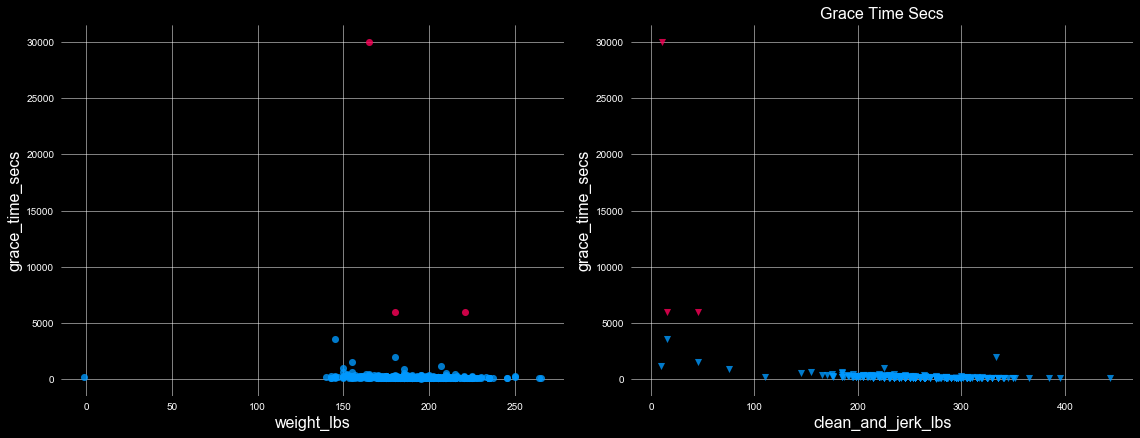

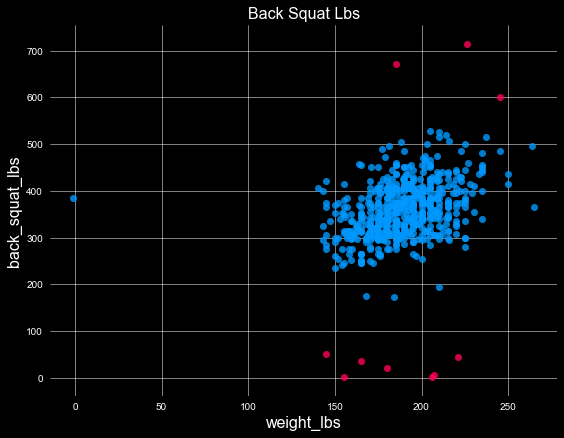

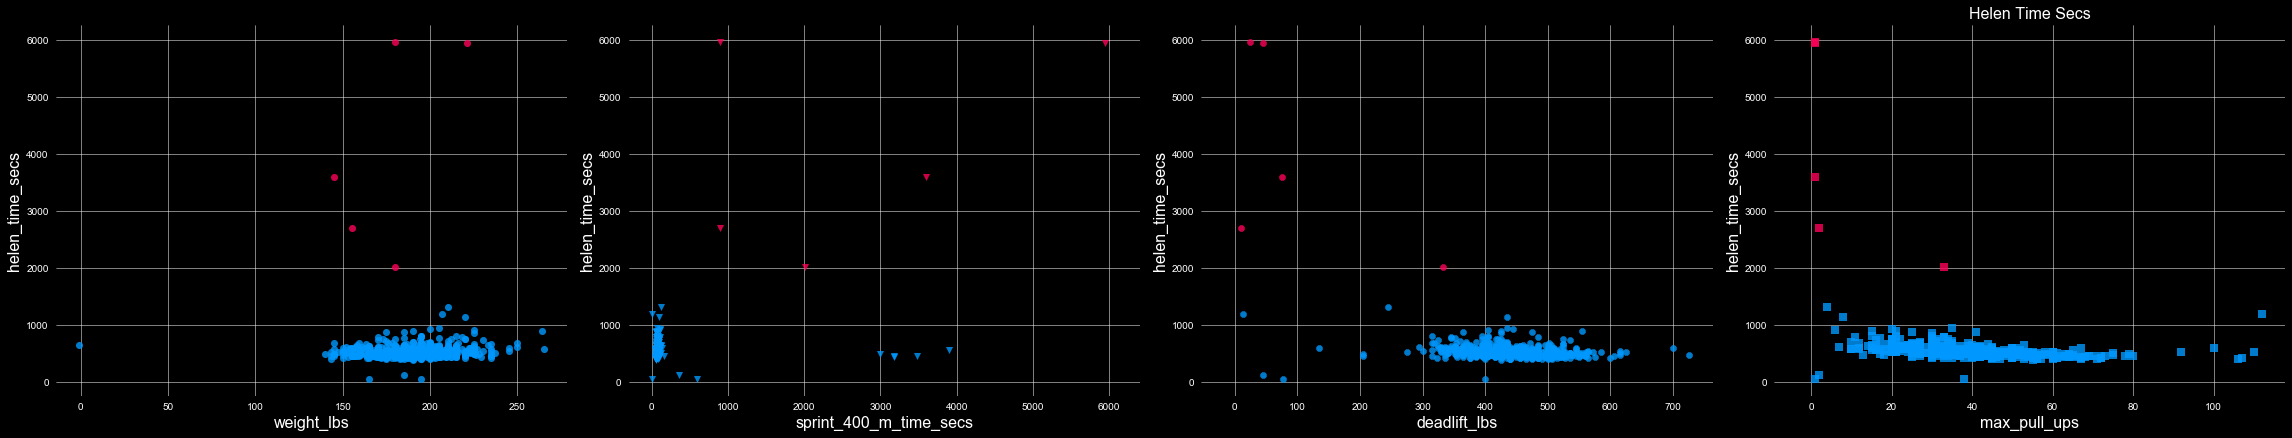

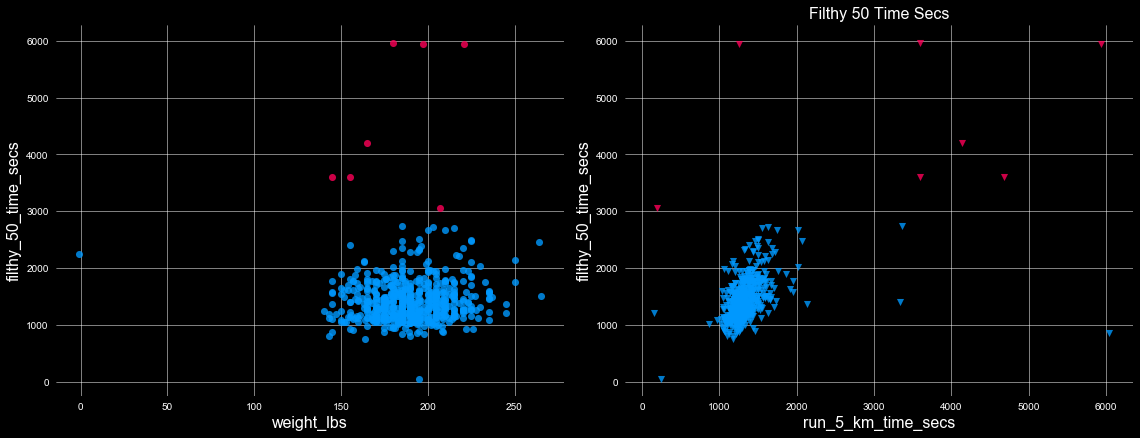

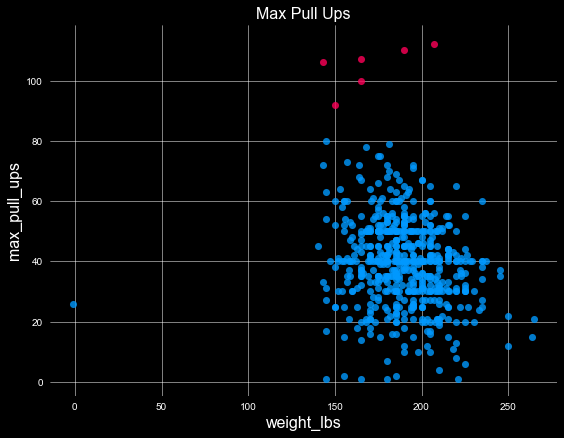

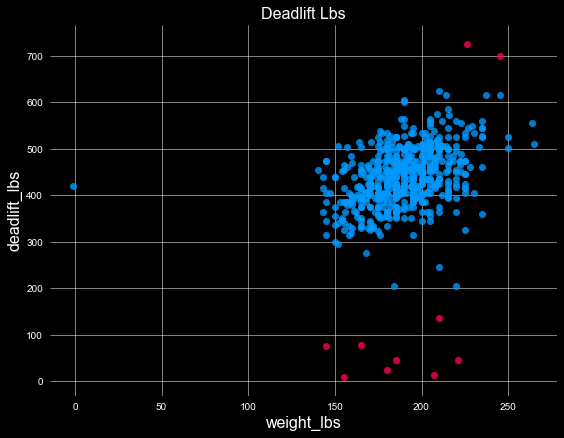

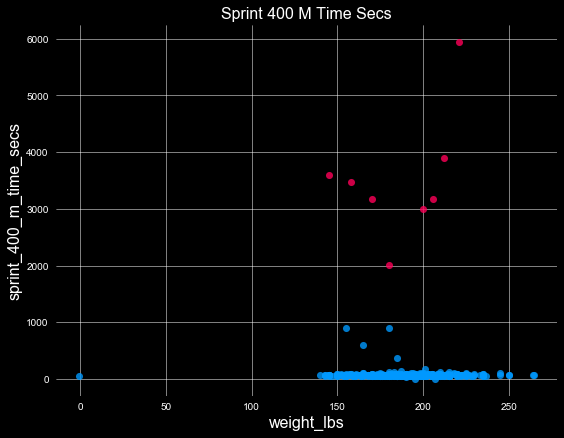

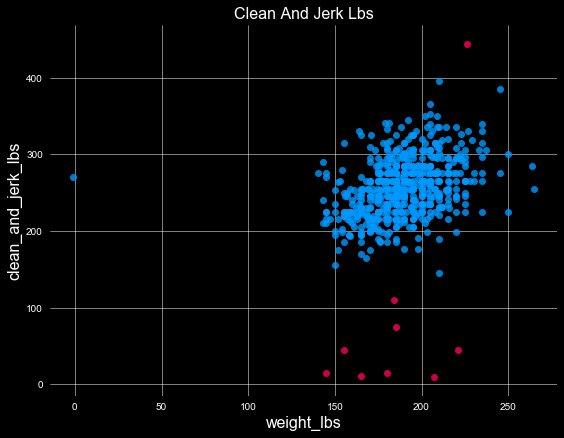

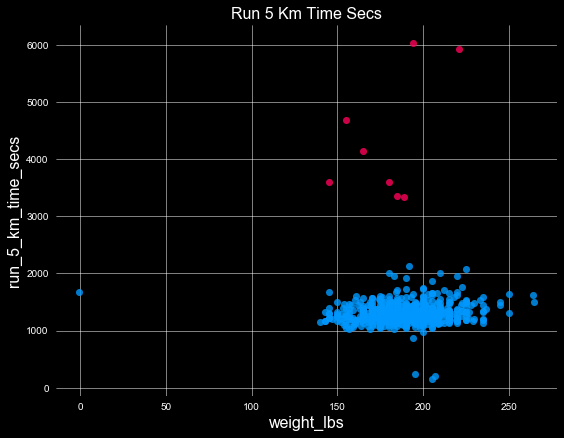

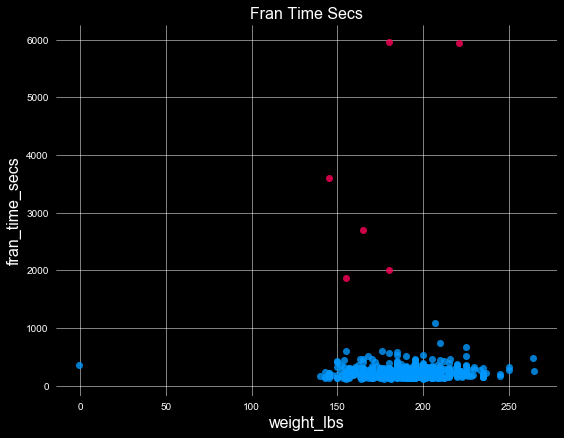

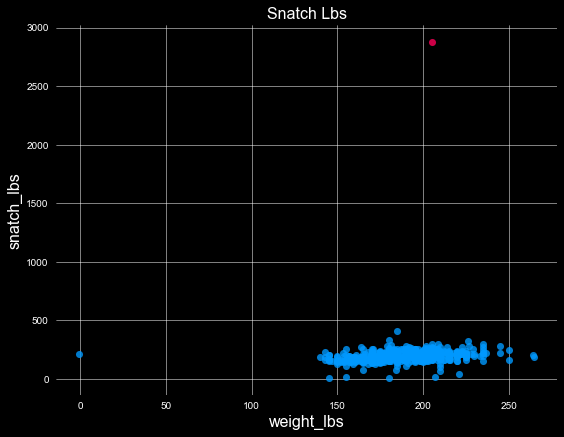

In [21]:
#plot data and grab abnormalities
abnormal_map = plot_benchmark_df(full_benchmark, replot_map, working_std_lim, benchmark_colors[:2])

### reanalyzing the data
After the data's been replotted versus bodyweight and other comparable benchmark metrics, we can get a wider perspective on who these outlier athletes are on a CrossFit performance-based level. What follows is the reevaluation of the data.

In [22]:
reanalysis_abnormal_ids = {}

#### general
It seems as though there's 1 athlete who has marked their weight as 0 lbs (or 0 kgs). This athlete will be removed.

In [23]:
reanalysis_abnormal_ids[full_benchmark[full_benchmark["weight_lbs"] < 50]["id"].values[0]] = 1
reanalysis_abnormal_ids

{202615: 1}

#### helen
Although the helen plots are difficult to read due to resolution limitations (I think this is Jupyter side for in-notebook visualizations), there are 5 clear outliers for Helen times. These athletes will be removed.

In [24]:
#helen abnormalities
abnormal_map["helen_time_secs"]

,id,height_in,weight_lbs,back_squat_lbs,clean_and_jerk_lbs,snatch_lbs,deadlift_lbs,max_pull_ups,fran_time_secs,grace_time_secs,helen_time_secs,filthy_50_time_secs,sprint_400_m_time_secs,run_5_km_time_secs
59,6038,77,221,45,45,45,45,1,5940,5940,5940,5940,5940,5940
142,19407,69,180,333,333,333,333,33,2013,2013,2013,2013,2013,2013
352,148052,64,145,50,15,10,75,1,3600,3600,3600,3600,3600,3600
552,1185595,66,155,2,45,15,10,2,1859,1538,2700,3599,901,4682
553,1231725,71,180,20,15,10,25,1,5955,5955,5955,5955,900,3600


In [25]:
for i in abnormal_map["helen_time_secs"]["id"]:
    reanalysis_abnormal_ids[i] = 1
len(reanalysis_abnormal_ids)

6

#### snatch
There's one athlete who claims to have snatched over 1000lbs. This outlier deviates so far from the visualized mean, it's possible that other outliers exist and are being masked by it's presence. Looking at the athlete profile [here](https://games.crossfit.com/athlete/9217), it seems likely the athlete meant to enter 287.5 instead of 2875. We'll ammend this entry in the dataframe.

In [26]:
#snatch abnormalities
abnormal_map["snatch_lbs"]

,id,height_in,weight_lbs,back_squat_lbs,clean_and_jerk_lbs,snatch_lbs,deadlift_lbs,max_pull_ups,fran_time_secs,grace_time_secs,helen_time_secs,filthy_50_time_secs,sprint_400_m_time_secs,run_5_km_time_secs
84,9217,71,205,450,325,2875,500,65,135,105,451,975,61,1245


In [27]:
full_benchmark.iat[84, 5] = 287
full_benchmark[full_benchmark["id"] == 9217]

,id,height_in,weight_lbs,back_squat_lbs,clean_and_jerk_lbs,snatch_lbs,deadlift_lbs,max_pull_ups,fran_time_secs,grace_time_secs,helen_time_secs,filthy_50_time_secs,sprint_400_m_time_secs,run_5_km_time_secs
84,9217,71,205,450,325,287,500,65,135,105,451,975,61,1245


However, let's also take the time to look at athletes who claim high snatches and see if anything pops out.

In [28]:
full_benchmark[full_benchmark["snatch_lbs"] > 275]

,id,height_in,weight_lbs,back_squat_lbs,clean_and_jerk_lbs,snatch_lbs,deadlift_lbs,max_pull_ups,fran_time_secs,grace_time_secs,helen_time_secs,filthy_50_time_secs,sprint_400_m_time_secs,run_5_km_time_secs
7,1974,65,179,473,341,280,475,50,147,126,511,1231,67,1268
9,2220,69,205,528,352,297,506,60,128,80,475,1278,62,1232
60,6151,69,181,495,341,290,495,70,122,94,455,952,55,1185
84,9217,71,205,450,325,287,500,65,135,105,451,975,61,1245
104,11826,72,209,475,350,300,575,50,138,101,436,875,65,1118
142,19407,69,180,333,333,333,333,33,2013,2013,2013,2013,2013,2013
162,24354,72,227,460,330,279,545,25,277,104,575,1508,70,1316
188,31660,70,202,475,350,280,500,53,133,79,439,1049,50,1225
199,35407,70,190,425,315,280,605,55,144,99,462,1045,60,1270
214,39277,69,185,671,75,407,45,2,585,935,135,2745,364,3355


Athlete [19407](https://games.crossfit.com/athlete/19407) claims 333 for each of the 4 lifts. In fact, after inspecting their profile, they only enter 3 for every input.

Additionally, although it isn't a snatch-specific outlier, [39277](https://games.crossfit.com/athlete/39277) has a 45lbs/75lbs deadlift/CJ, which is impossible given their listed back squat and snatch.

Both of these profiles will be removed.

In [29]:
reanalysis_abnormal_ids[19407] = 1
reanalysis_abnormal_ids[39277] = 1
len(reanalysis_abnormal_ids)

7

#### filthy 50
7 athletes have abnormally high Filthy 50 times. Additionally, although not highlighted, 1 athlete has a rather low time (almost 0). We'll remove the 7 normal athletes and this rather low time.

In [30]:
#low filthy 50 time
full_benchmark[full_benchmark["filthy_50_time_secs"] < 100]

,id,height_in,weight_lbs,back_squat_lbs,clean_and_jerk_lbs,snatch_lbs,deadlift_lbs,max_pull_ups,fran_time_secs,grace_time_secs,helen_time_secs,filthy_50_time_secs,sprint_400_m_time_secs,run_5_km_time_secs
259,69521,70,195,355,275,230,400,38,226,30,60,50,4,240


In [31]:
for i in abnormal_map["filthy_50_time_secs"]["id"]:
    reanalysis_abnormal_ids[i] = 1
#rather low time
reanalysis_abnormal_ids[69521] = 1
len(reanalysis_abnormal_ids)

11

#### run 5km
8 athletes have abnormally high 5k times. Additionally, some athletes claim to have sub-[world record](https://en.wikipedia.org/wiki/5000_metres_world_record_progression) times in the 5k which are not highlighted (12:37.35 for men is the WR). We'll remove all of these athletes.

In [32]:
full_benchmark[full_benchmark["run_5_km_time_secs"] <= 12 * 60 + 37.35]

,id,height_in,weight_lbs,back_squat_lbs,clean_and_jerk_lbs,snatch_lbs,deadlift_lbs,max_pull_ups,fran_time_secs,grace_time_secs,helen_time_secs,filthy_50_time_secs,sprint_400_m_time_secs,run_5_km_time_secs
259,69521,70,195,355,275,230,400,38,226,30,60,50,4,240
274,80003,74,207,7,10,15,13,112,1081,1199,1198,3050,2,195
366,170657,71,205,405,265,225,510,52,160,167,470,1202,69,153


In [33]:
for i in abnormal_map["run_5_km_time_secs"]["id"]:
    reanalysis_abnormal_ids[i] = 1
#notice we have already removed one/some of these ideas
for i in [69521, 80003, 170657]:
    reanalysis_abnormal_ids[i] = 1
len(reanalysis_abnormal_ids)

14

#### sprint 400m
8 athletes have been highlighted as outliers. However, it seems as though 4 athletes hover well above the mean, exceeding 300 seconds (5 minutes) or more. Although this is possible if the athletes have a disability, we're trying to fit a model for the average athlete, so these 4 entries will also be removed.

In [34]:
#high but not highlighted times
abnormal_sprints = full_benchmark[(full_benchmark["sprint_400_m_time_secs"] >= 300) & (full_benchmark["sprint_400_m_time_secs"] <= 1000)]
abnormal_sprints

,id,height_in,weight_lbs,back_squat_lbs,clean_and_jerk_lbs,snatch_lbs,deadlift_lbs,max_pull_ups,fran_time_secs,grace_time_secs,helen_time_secs,filthy_50_time_secs,sprint_400_m_time_secs,run_5_km_time_secs
214,39277,69,185,671,75,407,45,2,585,935,135,2745,364,3355
382,189562,69,165,35,11,77,77,1,2700,30002,61,4196,600,4140
552,1185595,66,155,2,45,15,10,2,1859,1538,2700,3599,901,4682
553,1231725,71,180,20,15,10,25,1,5955,5955,5955,5955,900,3600


In [35]:
for i in abnormal_map["sprint_400_m_time_secs"]["id"]:
    reanalysis_abnormal_ids[i] = 1
for i in abnormal_sprints["id"]:
    reanalysis_abnormal_ids[i] = 1
len(reanalysis_abnormal_ids)

19

#### grace
There are 3 athletes marked as outliers from the grace visuals. However, Grace is a workout which is to be performed with 135lbs, and there are some athletes who record a Grace time despite having a clean and jerk record < 135lbs. In addition to the 3 highlighted athletes, all athletes with a clean and jerk < 135 will be removed.

Additionally, Grace is meant to be a sub 10 minute workout (1-5 minutes when weight is scaled correctly to athlete's performance). Although this isn't a "hard" reason to remove any individual as an outlier, athletes doing the workout beyond 10 minutes are kind of missing the point, and it leads me to question their knowledge/integrity in general. I understand there's athletes who *can* complete Grace at Rx (135lbs for men) but require more than 10 minutes, however, they are not what we're trying to fit a learner to learn. Therefore, all athletes with Grace times exceeding 600 seconds will be pruned as well. This same standard will be upheld for Fran.

In [36]:
#grace abnormalities
abnormal_map["grace_time_secs"]

,id,height_in,weight_lbs,back_squat_lbs,clean_and_jerk_lbs,snatch_lbs,deadlift_lbs,max_pull_ups,fran_time_secs,grace_time_secs,helen_time_secs,filthy_50_time_secs,sprint_400_m_time_secs,run_5_km_time_secs
59,6038,77,221,45,45,45,45,1,5940,5940,5940,5940,5940,5940
382,189562,69,165,35,11,77,77,1,2700,30002,61,4196,600,4140
553,1231725,71,180,20,15,10,25,1,5955,5955,5955,5955,900,3600


In [37]:
#too low clean and jerk
abnormal_grace_cj = full_benchmark[full_benchmark["clean_and_jerk_lbs"] < 135]
abnormal_grace_cj

,id,height_in,weight_lbs,back_squat_lbs,clean_and_jerk_lbs,snatch_lbs,deadlift_lbs,max_pull_ups,fran_time_secs,grace_time_secs,helen_time_secs,filthy_50_time_secs,sprint_400_m_time_secs,run_5_km_time_secs
59,6038,77,221,45,45,45,45,1,5940,5940,5940,5940,5940,5940
168,25383,182,184,173,110,80,205,37,186,184,494,1214,68,1282
214,39277,69,185,671,75,407,45,2,585,935,135,2745,364,3355
274,80003,74,207,7,10,15,13,112,1081,1199,1198,3050,2,195
352,148052,64,145,50,15,10,75,1,3600,3600,3600,3600,3600,3600
382,189562,69,165,35,11,77,77,1,2700,30002,61,4196,600,4140
552,1185595,66,155,2,45,15,10,2,1859,1538,2700,3599,901,4682
553,1231725,71,180,20,15,10,25,1,5955,5955,5955,5955,900,3600


In [38]:
#too long (time) grace
#removing these athletes will also remove all highlighted outliers
abnormal_grace_time = full_benchmark[full_benchmark["grace_time_secs"] > 600]
abnormal_grace_time

,id,height_in,weight_lbs,back_squat_lbs,clean_and_jerk_lbs,snatch_lbs,deadlift_lbs,max_pull_ups,fran_time_secs,grace_time_secs,helen_time_secs,filthy_50_time_secs,sprint_400_m_time_secs,run_5_km_time_secs
59,6038,77,221,45,45,45,45,1,5940,5940,5940,5940,5940,5940
142,19407,69,180,333,333,333,333,33,2013,2013,2013,2013,2013,2013
214,39277,69,185,671,75,407,45,2,585,935,135,2745,364,3355
245,55663,66,150,290,225,155,375,38,190,972,422,1055,66,1260
274,80003,74,207,7,10,15,13,112,1081,1199,1198,3050,2,195
352,148052,64,145,50,15,10,75,1,3600,3600,3600,3600,3600,3600
382,189562,69,165,35,11,77,77,1,2700,30002,61,4196,600,4140
539,758561,69,150,260,155,125,300,25,412,615,555,1889,92,1493
552,1185595,66,155,2,45,15,10,2,1859,1538,2700,3599,901,4682
553,1231725,71,180,20,15,10,25,1,5955,5955,5955,5955,900,3600


In [39]:
for i in (list(abnormal_grace_cj["id"]) + list(abnormal_grace_time["id"])):
    reanalysis_abnormal_ids[i] = 1
len(reanalysis_abnormal_ids)

22

#### back squat
Aside from the highlighted outliers, nothing jumps out from the back squat plot. However, let's examine the athlete profiles for high back squat individuals.

In [40]:
abnormal_map["back_squat_lbs"]

,id,height_in,weight_lbs,back_squat_lbs,clean_and_jerk_lbs,snatch_lbs,deadlift_lbs,max_pull_ups,fran_time_secs,grace_time_secs,helen_time_secs,filthy_50_time_secs,sprint_400_m_time_secs,run_5_km_time_secs
59,6038,77,221,45,45,45,45,1,5940,5940,5940,5940,5940,5940
73,7823,70,206,2,297,253,477,48,155,114,533,1320,64,1320
214,39277,69,185,671,75,407,45,2,585,935,135,2745,364,3355
273,79664,68,226,715,444,323,726,42,165,90,482,932,72,1216
274,80003,74,207,7,10,15,13,112,1081,1199,1198,3050,2,195
323,116663,67,245,600,385,285,700,35,203,118,593,1367,98,1493
352,148052,64,145,50,15,10,75,1,3600,3600,3600,3600,3600,3600
382,189562,69,165,35,11,77,77,1,2700,30002,61,4196,600,4140
552,1185595,66,155,2,45,15,10,2,1859,1538,2700,3599,901,4682
553,1231725,71,180,20,15,10,25,1,5955,5955,5955,5955,900,3600


[79664](https://games.crossfit.com/athlete/79664) exhibits a high back squat, but his profile looks legitimate so he will be kept.

[116663](https://games.crossfit.com/athlete/116663): same as 79664.

[39277](https://games.crossfit.com/athlete/39277) has already been removed during snatch anaylsis due to suspicious deadlift/CJ scores.

In [41]:
abnormal_squats = list(abnormal_map["back_squat_lbs"]["id"])
abnormal_squats.remove(79664)
abnormal_squats.remove(116663)
abnormal_squats

[6038, 7823, 39277, 80003, 148052, 189562, 1185595, 1231725]

In [42]:
for i in abnormal_squats:
    reanalysis_abnormal_ids[i] = 1
len(reanalysis_abnormal_ids)

23

#### deadlift
8 athletes have been highlighted as outliers with low deadlift scores, whereas 2 athletes have been marked as outlier-like with high deadlift scores (these athletes were previously analyzed and approved in back squat analysis). The low deadlifting athletes will be removed, seeing as how it's very unusual that athletes cannot deadlift atleast their own bodyweight (and all of these have recorded they cannot).

In [43]:
abnormal_map["deadlift_lbs"]

,id,height_in,weight_lbs,back_squat_lbs,clean_and_jerk_lbs,snatch_lbs,deadlift_lbs,max_pull_ups,fran_time_secs,grace_time_secs,helen_time_secs,filthy_50_time_secs,sprint_400_m_time_secs,run_5_km_time_secs
18,2913,66,210,515,395,105,135,51,264,87,602,1440,80,1476
59,6038,77,221,45,45,45,45,1,5940,5940,5940,5940,5940,5940
214,39277,69,185,671,75,407,45,2,585,935,135,2745,364,3355
273,79664,68,226,715,444,323,726,42,165,90,482,932,72,1216
274,80003,74,207,7,10,15,13,112,1081,1199,1198,3050,2,195
323,116663,67,245,600,385,285,700,35,203,118,593,1367,98,1493
352,148052,64,145,50,15,10,75,1,3600,3600,3600,3600,3600,3600
382,189562,69,165,35,11,77,77,1,2700,30002,61,4196,600,4140
552,1185595,66,155,2,45,15,10,2,1859,1538,2700,3599,901,4682
553,1231725,71,180,20,15,10,25,1,5955,5955,5955,5955,900,3600


In [44]:
abnormal_deadlift = list(abnormal_map["deadlift_lbs"].id)
abnormal_deadlift.remove(79664)
abnormal_deadlift.remove(116663)
for i in abnormal_deadlift:
    reanalysis_abnormal_ids[i] = 1
len(reanalysis_abnormal_ids)

24

#### clean and jerk
9 athletes have been higlighted as having abnormal clean and jerks. One of these is [79664](https://games.crossfit.com/athlete/79664). The others will be removed.

It's also important to note here that we could have added 79664 to the dictionary with everyone else (more than once), removed *every* abnormality, and then added in *safe* entries afterwards. This would have been a more efficient (at the time) method.

In [45]:
abnormal_map["clean_and_jerk_lbs"]

,id,height_in,weight_lbs,back_squat_lbs,clean_and_jerk_lbs,snatch_lbs,deadlift_lbs,max_pull_ups,fran_time_secs,grace_time_secs,helen_time_secs,filthy_50_time_secs,sprint_400_m_time_secs,run_5_km_time_secs
59,6038,77,221,45,45,45,45,1,5940,5940,5940,5940,5940,5940
168,25383,182,184,173,110,80,205,37,186,184,494,1214,68,1282
214,39277,69,185,671,75,407,45,2,585,935,135,2745,364,3355
273,79664,68,226,715,444,323,726,42,165,90,482,932,72,1216
274,80003,74,207,7,10,15,13,112,1081,1199,1198,3050,2,195
352,148052,64,145,50,15,10,75,1,3600,3600,3600,3600,3600,3600
382,189562,69,165,35,11,77,77,1,2700,30002,61,4196,600,4140
552,1185595,66,155,2,45,15,10,2,1859,1538,2700,3599,901,4682
553,1231725,71,180,20,15,10,25,1,5955,5955,5955,5955,900,3600


In [46]:
abnormal_cj = list(abnormal_map["clean_and_jerk_lbs"]["id"])
abnormal_cj.remove(79664)
abnormal_cj

[6038, 25383, 39277, 80003, 148052, 189562, 1185595, 1231725]

In [47]:
for i in abnormal_cj:
    reanalysis_abnormal_ids[i] = 1
len(reanalysis_abnormal_ids)

24

#### max pull ups
6 athletes have been identified as having abnormally high pull up counts. This metric is difficult to discern, because there aren't many bodyweight-specific comparables as benchmarks on the athlete profile. Generally, I'd expect higher rep pull up athletes to associate with lower bodyweight and good Fran/Helen scores.

In [48]:
abnormal_map["max_pull_ups"]

,id,height_in,weight_lbs,back_squat_lbs,clean_and_jerk_lbs,snatch_lbs,deadlift_lbs,max_pull_ups,fran_time_secs,grace_time_secs,helen_time_secs,filthy_50_time_secs,sprint_400_m_time_secs,run_5_km_time_secs
64,6572,67,165,455,325,255,505,107,131,105,433,972,63,1230
176,27065,65,143,400,290,235,440,106,128,117,416,798,63,1172
254,63297,73,190,325,250,190,565,110,228,136,530,1562,62,1183
274,80003,74,207,7,10,15,13,112,1081,1199,1198,3050,2,195
348,143549,65,150,370,235,185,440,92,141,158,537,1240,62,1160
421,252802,66,165,315,240,165,395,100,270,295,595,1653,110,1380


[6572](https://games.crossfit.com/athlete/6572) meets this criteria and places highly in the Open, so their entry will be kept.

[27065](https://games.crossfit.com/athlete/27065) is none other than Chris Spealler. He's a legend and a true anomaly.

[63297](https://games.crossfit.com/athlete/63297) is a 6'1" 190lb athlete with decent Fran/Helen scores but poor Open placements (but above average). Without certainty of score validity, this athlete will be removed.

[80003](https://games.crossfit.com/athlete/80003) has no usable information in their athlete profile. This entry will be removed.

[143549](https://games.crossfit.com/athlete/143549) is a short/light athlete with above average Open placement and a good Fran time. This athlete's profile will be kept.

[252802](https://games.crossfit.com/athlete/252802) is a shorter/light athlete, but their Fran/Helen times are only average in CrossFit terms, so this profile will be removed.

In [49]:
abnormal_pull_up_good_ids = [6572, 27065, 143549]
abnormal_pull_ups = [i for i in list(abnormal_map["max_pull_ups"]["id"]) if i not in abnormal_pull_up_good_ids]
abnormal_pull_ups

[63297, 80003, 252802]

In [50]:
for i in abnormal_pull_ups:
    reanalysis_abnormal_ids[i] = 1
len(reanalysis_abnormal_ids)

26

#### fran
6 athletes were highlighted as abrnomally high scoring in Fran. From these profiles, they're all low-effort entry profiles, so they should all be removed. However, similar to Grace (see Grace section for explanation), any athlete with a time exceeding 600 seconds will be pruned.

In [51]:
abnormal_map["fran_time_secs"]

,id,height_in,weight_lbs,back_squat_lbs,clean_and_jerk_lbs,snatch_lbs,deadlift_lbs,max_pull_ups,fran_time_secs,grace_time_secs,helen_time_secs,filthy_50_time_secs,sprint_400_m_time_secs,run_5_km_time_secs
59,6038,77,221,45,45,45,45,1,5940,5940,5940,5940,5940,5940
142,19407,69,180,333,333,333,333,33,2013,2013,2013,2013,2013,2013
352,148052,64,145,50,15,10,75,1,3600,3600,3600,3600,3600,3600
382,189562,69,165,35,11,77,77,1,2700,30002,61,4196,600,4140
552,1185595,66,155,2,45,15,10,2,1859,1538,2700,3599,901,4682
553,1231725,71,180,20,15,10,25,1,5955,5955,5955,5955,900,3600


In [52]:
abnormal_fran = full_benchmark[full_benchmark["fran_time_secs"] > 600]
abnormal_fran

,id,height_in,weight_lbs,back_squat_lbs,clean_and_jerk_lbs,snatch_lbs,deadlift_lbs,max_pull_ups,fran_time_secs,grace_time_secs,helen_time_secs,filthy_50_time_secs,sprint_400_m_time_secs,run_5_km_time_secs
59,6038,77,221,45,45,45,45,1,5940,5940,5940,5940,5940,5940
142,19407,69,180,333,333,333,333,33,2013,2013,2013,2013,2013,2013
274,80003,74,207,7,10,15,13,112,1081,1199,1198,3050,2,195
352,148052,64,145,50,15,10,75,1,3600,3600,3600,3600,3600,3600
374,178221,74,210,195,145,65,245,4,733,557,1325,2663,123,2014
382,189562,69,165,35,11,77,77,1,2700,30002,61,4196,600,4140
530,709436,71,225,375,225,160,405,6,663,179,910,2484,108,2071
552,1185595,66,155,2,45,15,10,2,1859,1538,2700,3599,901,4682
553,1231725,71,180,20,15,10,25,1,5955,5955,5955,5955,900,3600


In [53]:
for i in abnormal_fran["id"]:
    reanalysis_abnormal_ids[i] = 1
len(reanalysis_abnormal_ids)

28

### removing outliers and replotting
After collecting many outliers (28), we can prune the `full_benchmark` dataframe and replot the data to get a purer visualization of athletes in this division.

In [60]:
#removal
pure_benchmarks = full_benchmark[~full_benchmark["id"].isin(reanalysis_abnormal_ids.keys())]
print(
    "{}/{} ({}%) atheltes remain after outlier removal.".format(
        len(pure_benchmarks),
        len(full_benchmark),
        round(100 * len(pure_benchmarks) / len(full_benchmark), 2)
    ),
)

#open data
pure_open = filtered_open_df[filtered_open_df["id"].isin(pure_benchmarks["id"])]

528/556 (94.96%) atheltes remain after outlier removal.


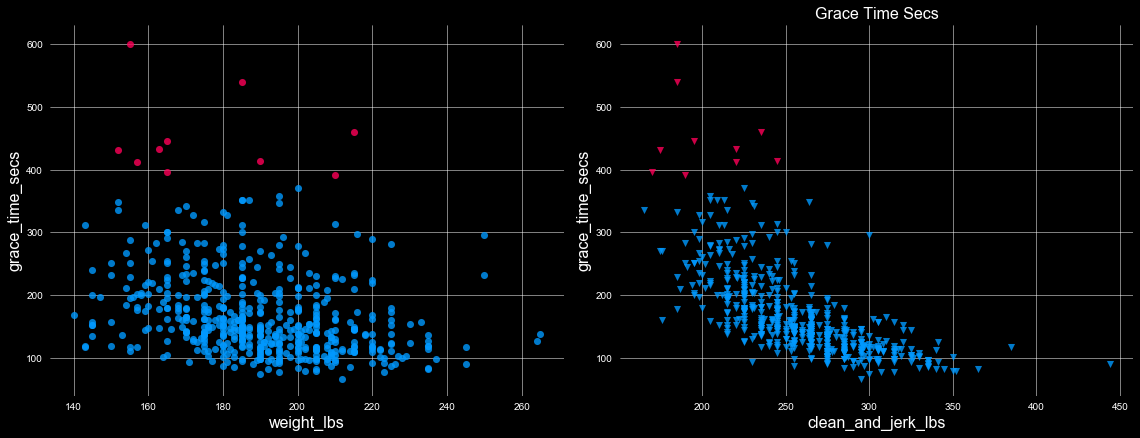

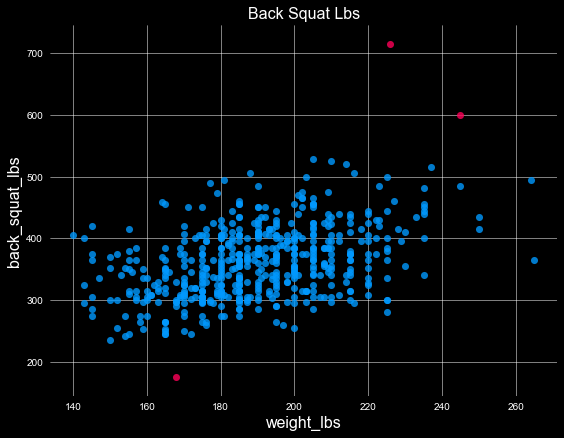

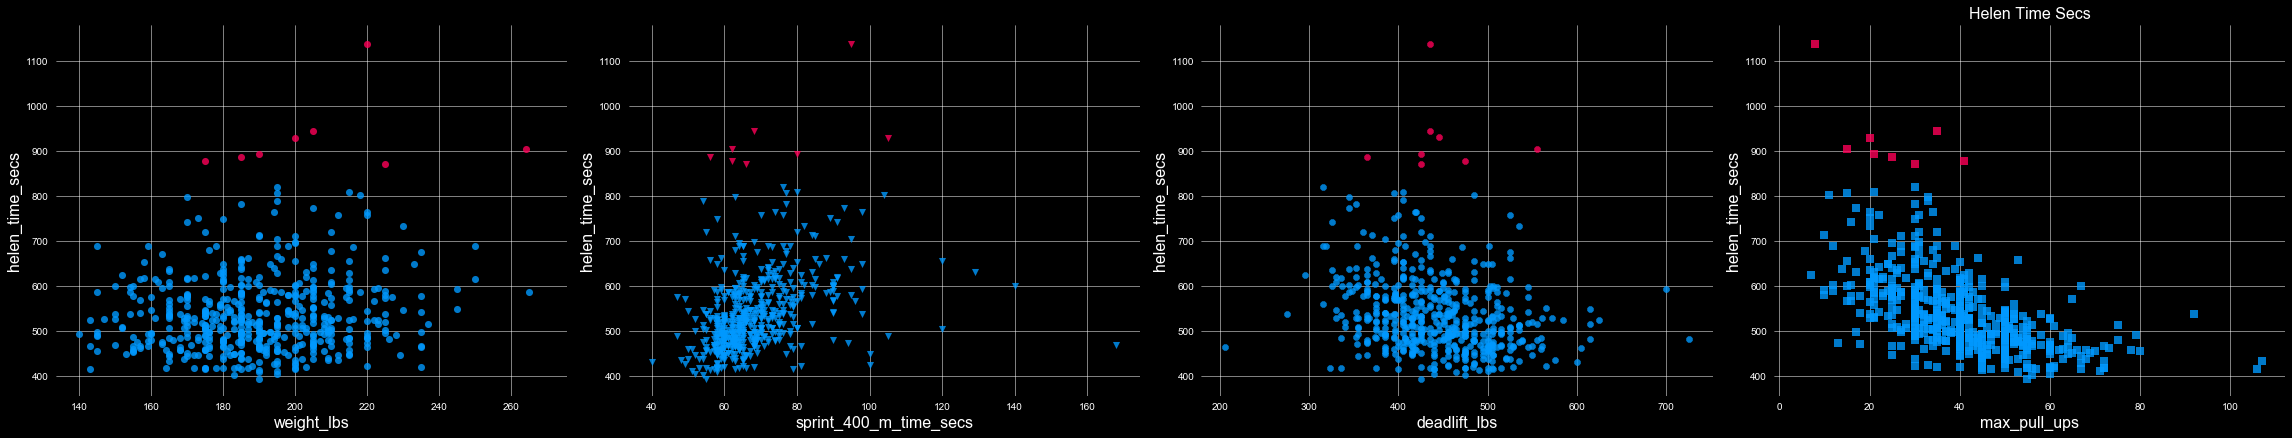

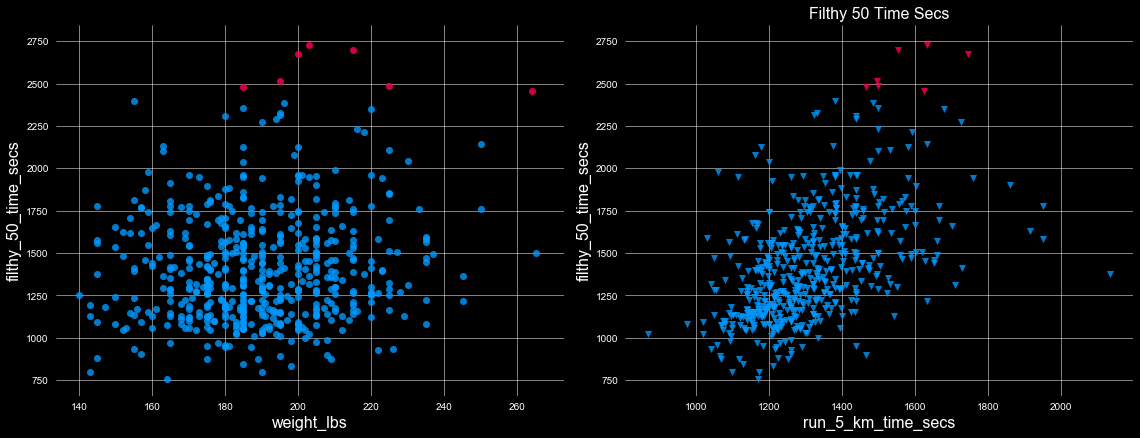

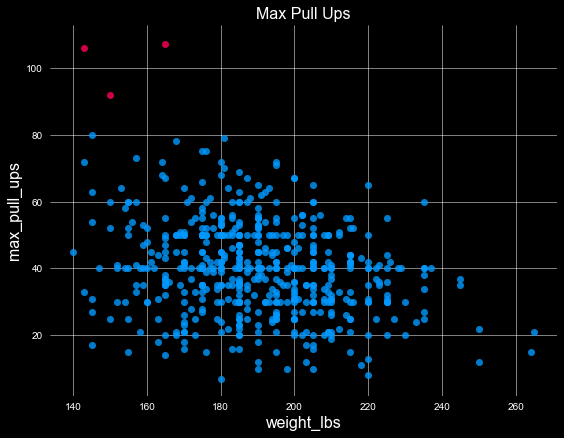

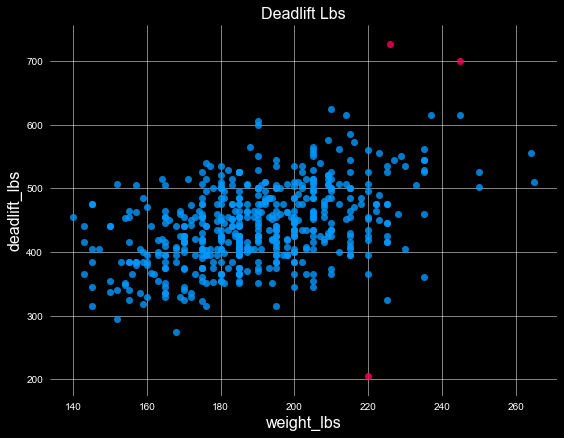

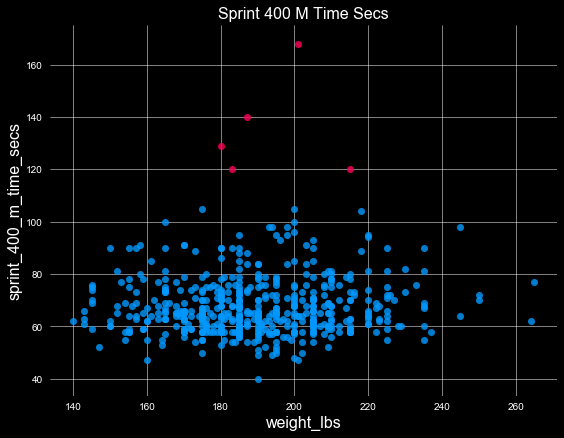

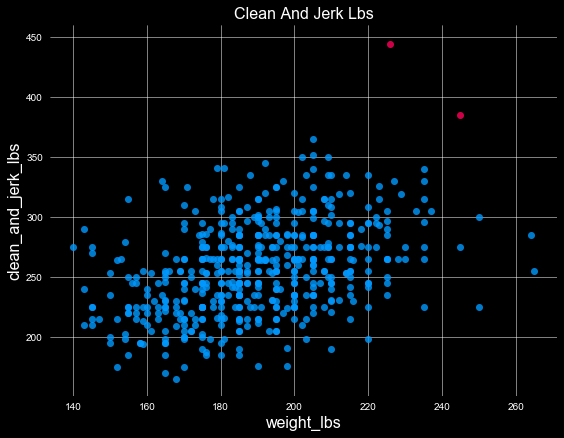

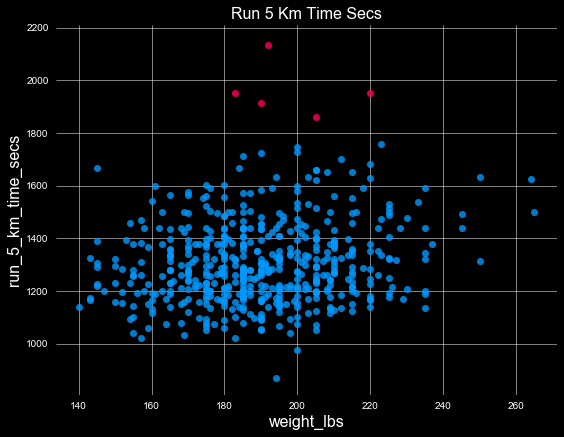

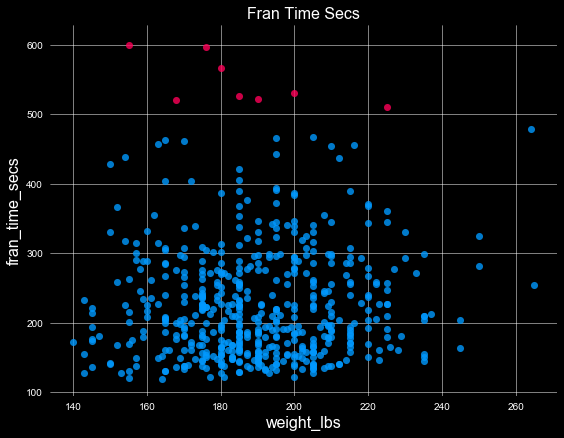

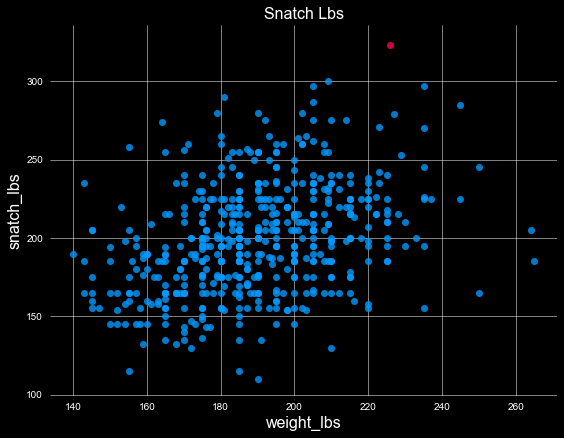

In [55]:
plot_benchmark_df(pure_benchmarks, replot_map, working_std_lim, benchmark_colors[:2], False)

## scaling the data
Before fitting this data to a learner, it's important to mention that these workouts are in a bunch of different metrics: weight, time, pounds. Because of this, we'll first scale the scale/normalize the data to the range [0,1]. In doing this, variable weights for say, deadlift, which can exceed a value of 600lbs (600), won't outweigh metrics which have lower values, like max pull ups (0-110).

However, it's common that models which measure distances/similarities between data entries (kNN) are more affected by feature scaling than those which do not (Naive Bayes). Because we're using a bayesian regression model from scikit-learn, it's likely that feature scaling is not necessary. However, we may choose to apply different learners later, so for now we'll do feature scaling.

In [ ]:
mms = MinMaxScaler()
#scaling open/benchmark dataframes


## splitting data into train/test sets

In [ ]:
#ratio of data to be used for testing
test_ratio = .2
#random state used for ML initialization
random_state = 0

In [ ]:
#doesn't really matter which variable is used here as (in)dependent
x_train, x_test, y_train, y_test = train_test_split(
    #x
    squat_deadlift.squat,
    #y
    squat_deadlift.deadlift,
    test_size=test_ratio,
    random_state=random_state
)

## linear regression
Below we apply scikit-learn's [linear regression](http://scikit-learn.org/stable/auto_examples/plot_isotonic_regression.html#sphx-glr-auto-examples-plot-isotonic-regression-py) to the squat/deadlift data, using squat weight (in lbs) to predict deadlift weight (in lbs). Note that these values are 1 rep maxes (the maximum amount of weight an athlete has attested to lifting for 1 rep).

In [ ]:
regressor = LinearRegression()
regressor.fit(x_train[:, np.newaxis], y_train)

### plotting regression
The data can be plotted using Seaborn's [regplot](https://seaborn.pydata.org/generated/seaborn.regplot.html).

In [ ]:
#colors for plotting
color_map = {
    "scatter": {
        "train": "#33ccff",
        "test": "#ff0059"
    },
    "regression": {
        "predict": "#66ff33"
    }
}

#training/testing dataframes
df_train = pd.concat([x_train, y_train], axis=1)
df_test = pd.concat([x_test, y_test], axis=1)
df_preds = pd.DataFrame(x_test.values, columns=["squat"])
df_preds["deadlift"] = pd.Series(regressor.predict(x_test.values[:, np.newaxis]))

#used to make plotting less repetitive
colors_scatter = [color_map["scatter"]["train"], color_map["scatter"]["test"]]
labels = ["train", "test"]
dfs = [df_train, df_test]

#plotting scatter plots
for i in range(len(dfs)):
    ax = sb.regplot(
        x="squat",
        y="deadlift",
        data=dfs[i],
        fit_reg=False,#default true
        color=colors_scatter[i],
        scatter_kws={"s": 25},
        label=labels[i],
        marker="o"
    )

#plotting regression (from model predicting based on x_test)
ax = sb.regplot(
    x="squat",
    y="deadlift",
    data=df_preds.head(2),
    scatter=False,#default true
    color=color_map["regression"]["predict"],
    label="predict"
)
plt.title("Squat vs. Deadlift (lbs)")
plt.legend()
plt.show()
#testing data
#ax = sb.regplot(x="squat", y="deadlift", data=df_test, fit_reg=False, color=colors["scatter"]["test"])

## analyzing regression fit
The regression looks like it fits the data well, but because the data has a decent spread, let's use some metrics to analyze it's performance.

In [ ]:
#r2
print(
    "R2 score: {}".format(
        regressor.score(
            df_test["squat"][:, np.newaxis],
            df_test["deadlift"][:, np.newaxis]
        )
    )
)

#rmse
print(
    "RMSE: {}".format(
        mean_squared_error(
            df_test["deadlift"][:, np.newaxis],
            df_preds["deadlift"][:, np.newaxis]
        )
    )
)

Analyziing the R2 specifically, it seems as though only 50% of the variation in deadlifts observed in the women's 45-49 division can be explained by looking at the back squat. Because of this, observing the back squat alone is most likely not a strong enough metric to try and predict athlete deadlifts. However, explaining 50% of the deadlift variation IS significant. Perhaps this regression could be done again, taking into account cleans, snatches, or 2k rows.